## Key Concepts

### learning about the system with the interactions to the systems.
-> rewards and punishments can be delayed in time from the action.(temporal disconnect.) <br>
-> u might not get an evaluation from the input immediately.(state and reward is our imagination)<br>
-> why not put vector reward.
-> I do not have errors at every point/action.eg:writing an exam
->Fundamental idea in rl
 * Intuition: The predictions i have at 't+1' are better than those at 't'(temporal difference learning)
 
### create a tic-tac-toe in python and try to find the solution.

->Say i'm at a particular board position and i managed to have some estimate of expected rewards..then i got to explore...say i'm at a board position with possible next step probabilities as (0.2,0.8,0.1) ..for fun i took the one with 0.2..then shall i update my vs.


---------
start with immediate reinforcement learning problem.
Give a drug and test(at,rt,and )..outcome can be stochastic...(what is the optimal way to learn from a stocahstice environment).

### Developing practical insight into probability. - motivating question.
(how to know about a stochastic environment...given you can sample.?)

-> coin flip,bayes rule,prior -> optimallearning.


In [7]:
import torch
import matplotlib.pyplot as plt

In [13]:
a = torch.randn(10000)

(array([   8.,   91.,  534., 1712., 2926., 2731., 1516.,  423.,   53.,
           6.]),
 array([-3.8676198 , -3.082831  , -2.298042  , -1.5132532 , -0.72846437,
         0.05632448,  0.8411133 ,  1.6259022 ,  2.410691  ,  3.1954799 ,
         3.9802687 ], dtype=float32),
 <a list of 10 Patch objects>)

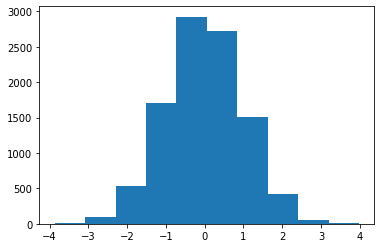

In [14]:
plt.hist(a)


In [16]:
a.mean(),a.std()

(tensor(-0.0059), tensor(0.9857))

While reading the text reader should constantly be asking two questions:
    1.How can i implement this.-> 'ensures actual understanding and also brings engineering problems into the picture.'
    2.How can i be sure what i'm doing will work if implemented correctly. -> 'ensures rigor.'

### Immediate RL.

A = [1,2,3...n]

* Multi-arm Bandit problems:solution concepts
-> Asymptotic convergence.
-> Regret optimality
-> PAC complexity.(probably approximately correct)

1.value function based methods - q.
a.'E' greedy approach
b.softmax approach.(more intelligent approach.)

questions: What is the effect of using constant 'alpha' in case of stationary problems.(u will keep swinging back n forth.)


bandit based problems:
Regret optimality.
UCB(upper confidence bound):

In [1]:
import gym
from collections import namedtuple
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70


class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)


Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])


def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs
        
        
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs


def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

In [2]:
    env = gym.make("CartPole-v0")
    # env = gym.wrappers.Monitor(env, directory="mon", force=True)
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    net = Net(obs_size, HIDDEN_SIZE, n_actions)
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=net.parameters(), lr=0.01)
    
    for iter_no, batch in enumerate(iterate_batches(
            env, net, BATCH_SIZE)):
        obs_v, acts_v, reward_b, reward_m = \
            filter_batch(batch, PERCENTILE)
        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        loss_v = objective(action_scores_v, acts_v)
        loss_v.backward()
        optimizer.step()
        print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
        if reward_m > 199:
            print("Solved!")
            break

/Users/vinay/anaconda3/envs/fastai2/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0: loss=0.667, reward_mean=16.6, rw_bound=18.0
1: loss=0.679, reward_mean=25.4, rw_bound=32.0
2: loss=0.698, reward_mean=25.6, rw_bound=27.5
3: loss=0.668, reward_mean=23.2, rw_bound=26.0
4: loss=0.661, reward_mean=23.7, rw_bound=26.5
5: loss=0.663, reward_mean=28.8, rw_bound=35.0
6: loss=0.651, reward_mean=39.9, rw_bound=38.5
7: loss=0.650, reward_mean=36.7, rw_bound=41.0
8: loss=0.623, reward_mean=37.5, rw_bound=48.5
9: loss=0.623, reward_mean=52.4, rw_bound=58.5
10: loss=0.623, reward_mean=56.4, rw_bound=59.5
11: loss=0.606, reward_mean=58.3, rw_bound=67.0
12: loss=0.598, reward_mean=46.6, rw_bound=52.5
13: loss=0.589, reward_mean=50.6, rw_bound=58.5
14: loss=0.596, reward_mean=63.3, rw_bound=73.5
15: loss=0.593, reward_mean=68.1, rw_bound=70.0
16: loss=0.567, reward_mean=65.3, rw_bound=71.5
17: loss=0.570, reward_mean=73.6, rw_bound=86.5
18: loss=0.569, reward_mean=69.8, rw_bound=77.5
19: loss=0.553, reward_mean=81.2, rw_bound=89.5
20: loss=0.534, reward_mean=74.4, rw_bound=86.0
21